In [111]:
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
import pandas as pd
import json
from shapely.geometry import Polygon, Point, MultiPoint
from geopy.distance import distance
import random
import numpy as np
from collections import defaultdict
from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt

In [53]:
def generate_random_point(lat_bound, lon_bound, count, shape):
    coordinates = []
    lat_min, lat_max = lat_bound
    lon_min, lon_max = lon_bound
    for i in range(count):
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)
        while not shape.contains(Point(lon,lat)):
            lat = random.uniform(lat_min, lat_max)
            lon = random.uniform(lon_min, lon_max)
        coordinates.append(Point(lon, lat))
    return MultiPoint(coordinates)

In [54]:
def farthest_coord(coordinates, center_coord):
    coord_distance = 0
    farthest_coord = center_coord
    for index, point in enumerate(coordinates):
        curr_distance = distance(point.coords[0], farthest_coord.coords[0]).km
        if coord_distance < curr_distance:
            coord_distance = curr_distance
            farthest_point = point
    return point

In [55]:
def generate_circle_bounding_point(point, radius):
    centers = defaultdict(np.float64)
    posx, posy = point.coords[0]
    for x in np.arange(posx-radius, posx+radius, 0.01):
        for y in np.arange(posy-radius, posy+radius , 0.01):
            circle_point = Point(x, y)
            if distance(circle_point.coords[0], point.coords[0]).km <= np.float64(radius):
                centers[(x, y)] += 1
    if len(centers) < 1:
        raise Exception("No viable center found for point %d , %d" %(point.coords[0], point.coords[1]))
    return centers

In [56]:
def check_occurrences_in_circle(centers, points, radius):
    occurrences = defaultdict(int)
    points_in_circle = defaultdict(list)
    for index, point in enumerate(points):
        for center in centers:
            x, y = center
            center_point = Point(x, y)
            if distance(center_point.coords[0], point.coords[0]) <= radius:
                occurrences[center] += 1
                points_in_circle[center].append(index)
    best_circle_center = max(occurrences, key = lambda x: occurrences[x]) 
    return best_circle_center, points_in_circle[best_circle_center]

In [57]:
def multi_point_with_indexes_excluded(indexes, points):
    new_list = [points[i] for i, x in enumerate(points) if i not in indexes]
    return MultiPoint(new_list)

In [58]:
def maslak_clusters(coordinates, radius, coordinate_clusters):
    center_coord = coordinates.centroid
    farthest_point = farthest_coord(coordinates, center_coord)
    centers = generate_circle_bounding_point(farthest_point, radius)
    best_circle_center, points_in_circle = check_occurrences_in_circle(centers, coordinates, radius)
    coordinate_clusters[best_circle_center] = [coordinates[i] for i in points_in_circle]
    updated_coordinates = multi_point_with_indexes_excluded(points_in_circle, coordinates)
    print(len(updated_coordinates))
    if len(updated_coordinates) > 0:
        maslak_clusters(updated_coordinates, radius, coordinate_clusters)
    else:
        return

In [59]:
# Source: https://github.com/sahircansurmeli/istanbul-geojson
df = pd.read_json('maslak_coordinates.json')
maslak_shape = Polygon(df['coordinates'])
coordinate_clusters = defaultdict(list)
radius = 0.5 # km
coordinates_count = 1000
lat_bound = (maslak_shape.bounds[1], maslak_shape.bounds[3])
lon_bound = (maslak_shape.bounds[0], maslak_shape.bounds[2])
coordinates = generate_random_point(lat_bound, lon_bound, 1000, maslak_shape)

In [60]:
maslak_clusters(coordinates, radius, coordinate_clusters)

887
767
699
569
521
406
328
223
177
142
125
90
60
50
35
23
21
12
10
3
1
0


In [78]:
def get_addresses(coordinates):
    geolocator = Nominatim(user_agent="cluster_optimization")
    locations = defaultdict(str)
    for point in coordinates:
        coordinate = point.coords[0]
        location = geolocator.reverse(str(coordinate[1]) + ', ' + str(coordinate[0]))
        locations[coordinate] = location
    return locations

In [79]:
addresses = get_addresses(coordinates)

In [84]:
addresses

defaultdict(str,
            {(29.008319863966584,
              41.119047865884276): Location(MASLAK 1453 Ağaoğlu, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye, (41.118753006492064, 29.007344628870094, 0.0)),
             (29.024525436800328,
              41.13172717366618): Location(Fatih Ormanı Kampüsü, Büyükdere Caddesi, Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye, (41.13282485, 29.02402528768716, 0.0)),
             (29.01187555184087,
              41.11898691317606): Location(Lojman, AOS 17. Sokak, Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye, (41.1190136, 29.011503316500935, 0.0)),
             (29.008668177038476,
              41.11821202663334): Location(MASLAK 1453 Ağaoğlu, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye, (41.118041557978614, 29.008918341028387, 0.0)),
             (29.013949253951722,
              41.11947784710139): Location(Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye, (4

In [87]:
def print_coordinate_clusters(coordinate_clusters):
    cluster_no = 1
    for cluster in coordinate_clusters:
        print(f'SEPETNO#{cluster_no}')
        cluster_no += 1
        item_no = 1
        for point in coordinate_clusters[cluster]:
            link = f'https://www.openstreetmap.org/#map=19/{point.coords[0][1]}/{point.coords[0][0]}'
            print(f'\t item#{item_no} {point.coords[0][1]}, {point.coords[0][0]}, {addresses[(point.coords[0][0], point.coords[0][1])]} {link}')
            item_no += 1
        

In [88]:
print_coordinate_clusters(coordinate_clusters)

SEPETNO#1
	 item#1 41.12883765508986, 29.015959518893155, Fatih Ormanları Tabiat Parkı, Büyükdere Caddesi, Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye https://www.openstreetmap.org/#map=19/41.12883765508986/29.015959518893155
	 item#2 41.12425249573476, 29.014194440911883, Maslak Mahallesi, Ayazağa Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye https://www.openstreetmap.org/#map=19/41.12425249573476/29.014194440911883
	 item#3 41.127721769624785, 29.017516214789286, Fatih Ormanları Tabiat Parkı, Büyükdere Caddesi, Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye https://www.openstreetmap.org/#map=19/41.127721769624785/29.017516214789286
	 item#4 41.12705870900809, 29.01778352341895, Fatih Ormanları Tabiat Parkı, Büyükdere Caddesi, Maslak Mahallesi, Sarıyer, İstanbul, Marmara Bölgesi, 34485, Türkiye https://www.openstreetmap.org/#map=19/41.12705870900809/29.01778352341895
	 item#5 41.130725811545275, 29.013260922824035, Fatih O

In [207]:
def plot_clusters(df, min_x, max_x, min_y, max_y):
    plt.figure()
    i = 0
    for column in df:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(df))]
        if i < 6:
            i += 1
        else:
            i = 0
        for point in df[column]:
            if point != None:
                plt.scatter(point.coords[0][0], point.coords[0][1], color=color[i])
    plt.show()

In [208]:
df = gdf()
for cluster in coordinate_clusters:
    df[cluster] = gs(coordinate_clusters[cluster])

In [209]:
min_x, max_x = (maslak_shape.bounds[1], maslak_shape.bounds[3])
min_y, max_y = (maslak_shape.bounds[0], maslak_shape.bounds[2])

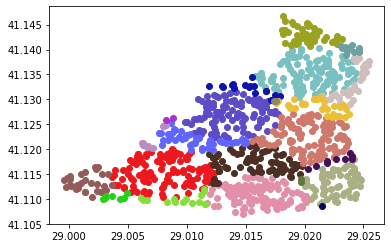

In [210]:
plot_clusters(df, min_x, max_x, min_y, max_y)